In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from scipy.stats import entropy
import copy


In [4]:
def getTrainingData(songStrings,nrOfSongs):
    notes=list("ABCDEFGH")
    chord=[[0],
           [1],
           [2],
           [3],
           [4],
           [5],
           [6],
           [7]]
    source=[]
    target=[]
    song=[]
    for s in range(nrOfSongs):
        for i in range(42):
            sentence=[]
            answer=[]
            song.append(s)
            for j in range(41):
                sentence.append(chord[notes.index(songStrings[s][(i+j)%42])][0])
                answer.append(chord[notes.index(songStrings[s][(i+j+1)%42])][0])
            source.append(sentence)
            target.append(answer)
    return numpy.array(source),numpy.array(target),numpy.array(song)

songStrings = numpy.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDEFABCDEFABCDEFABCDEFABCDEFABCDEFABCDEF",
    "ABACADAEAFABEFADECBABCFEDEFABCADEBACADFABE",
    "DBCACBCFFDCEFFEFCDDEFEBEACFECBBBCBECBFDAFB",
    "ABEBCAEFCDFFBCBDBBBCEDCBFBFFECBCEBCAAFFADB",
    "BEEFBAFDAEAAEFDBDFDEFCACEBCCDACEACACEEDBAA",
    "BFEBFEEBDBCFEAACAAAFDFCBFBFEAACFFCAABCEDDC",
    "BADDFFEADBEDFDFBEBCCADEFDEABBFDEFFEBEEFDEF",
    "ABFFEDBDBFECEDEAEBBEECFDDAEDCDBBFCADADBBCF",
    "DFBCEBDAADAAFCDACADDAFFACDCFCCDDDCFBEBBDED",
    "CCFBEFDDCBFDADDBFBCCEEABAFAAAEDCDCEAEFBFCD",
    "EBADFFAAFADDDABEABBDFDCAFBCDEEBBBECDDFEEAE",
    "AFADDFEFADDBCDCFEEFCAEEEDFFEDBCADBBDBAEFCD"])

I,O,S=getTrainingData(songStrings,1)
print(I.shape,O.shape,S.shape)

(42, 41) (42, 41) (42,)


In [6]:
print(I[0].flatten(),O[0].flatten())
print(I[1].flatten(),O[1].flatten())

[2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5
 4 4 3 3] [2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2]
[2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2] [6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4
 3 3 2 2]


In [85]:
class TransformerModel(nn.Module):
    def __init__(self, ntokens, emsize, nhead, d_hid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(emsize, dropout)
        encoder_layers = nn.TransformerEncoderLayer(emsize, nhead, d_hid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntokens, emsize)
        self.emsize = emsize
        self.decoder = nn.Linear(emsize, ntokens)
        self.ntokens=ntokens
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src,verbose=False):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.emsize)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        self.store=output.detach().numpy().copy()
        if verbose:
            print(output.shape)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Parameters
ntokens = 8  # size of vocabulary
emsize = 20  # embedding dimension
nhead = 4  # number of heads in the nn.MultiheadAttention
d_hid = 20  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.03  # dropout probability

# Initialize the model
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)


In [ ]:
def train(model, source, target, num_epochs=1000, learning_rate=1e-3):
    W=[]
    model.train()  # Set the model to training mode
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Assuming source and target are numpy arrays of shape (sentences, 41) and need to be converted to tensors
    source = torch.tensor(source, dtype=torch.long)
    target = torch.tensor(target, dtype=torch.long)
    
    for epoch in range(num_epochs):
        total_loss = 0
        
        # Here, we assume batching is handled externally, and source is directly fed into the model
        optimizer.zero_grad()  # Clear the gradients of all optimized tensors
        
        # Adjust for PyTorch expecting (sequence_length, batch_size), so we transpose source and target
        src = source.transpose(0, 1)  # Now shape [41, sentences]
        tgt = target.transpose(0, 1)  # Now shape [41, sentences]
        
        output = model(src)  # Forward pass: compute the output of the model
        
        # Output is [sequence_length, batch_size, ntokens], target is [sequence_length, batch_size]
        # Flatten output to [sequence_length*batch_size, ntokens] for compatibility with CrossEntropyLoss
        output_flat = output.view(-1, model.ntokens)
        tgt_flat = tgt.reshape(-1)
        
        loss = criterion(output_flat, tgt_flat)  # Compute the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)
        
        total_loss += loss.item()
        
        avg_loss = total_loss / src.size(1)  # average loss per sentence
        if epoch % 100 ==0:
            print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
            W.append(test(model,source,target))
            print("acc:",W[-1])
    return W
# Example usage
# Assuming `model` is your model instance, and `source`, `target` are your data tensors

ntokens = 8  # size of vocabulary
emsize = 20  # embedding dimension
nhead = 4  # number of heads in the nn.MultiheadAttention
d_hid = 20  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.03  # dropout probability

# Initialize the model
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

nrOfSongs=10
source,target,songs=getTrainingData(songStrings,nrOfSongs)

W=train(model, torch.tensor(source), torch.tensor(target),num_epochs=5000)
plot(W)

/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_85847/3156798142.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_85847/3156798142.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)
/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_85847/550002729.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/v5/p

Epoch 1, Loss: 0.0049
acc: 0.14907084785133565
Epoch 101, Loss: 0.0042
acc: 0.2753193960511034
Epoch 201, Loss: 0.0037
acc: 0.38501742160278746
Epoch 301, Loss: 0.0029
acc: 0.5161440185830429
Epoch 401, Loss: 0.0021
acc: 0.6451800232288037
Epoch 501, Loss: 0.0016
acc: 0.7366434378629501
Epoch 601, Loss: 0.0012
acc: 0.8113240418118467
Epoch 701, Loss: 0.0010
acc: 0.8557491289198607


In [88]:
def test(model, source, target):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    source = torch.tensor(source, dtype=torch.long)
    target = torch.tensor(target, dtype=torch.long)

    with torch.no_grad():  # No need to track gradients
        src = source.transpose(0, 1)  # Adjust for the expected input dimensions [sequence_length, batch_size]
        tgt = target.transpose(0, 1)  # Same adjustment for the target
        
        output = model(src)  # Compute the output
        
        # The output is [sequence_length, batch_size, ntokens]. Get the most likely token predictions
        predictions = output.argmax(dim=2)  # Get the index of the max log-probability
        
        correct += (predictions == tgt).sum().item()  # Count how many predictions match the target
        total += tgt.numel()  # Total number of predictions
        
    accuracy = correct / total  # Calculate the accuracy
    return accuracy

In [89]:
test(model,torch.tensor(source),torch.tensor(target))

/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_85847/550002729.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_85847/550002729.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


0.9677700348432056

In [90]:
def predict_next_token(model, token_indices,verbose=False):
    model.eval()  # Ensure the model is in evaluation mode
    
    # Convert the list of token indices to a PyTorch tensor and add a batch dimension
    src = torch.tensor(token_indices, dtype=torch.long).unsqueeze(1)  # Shape [sequence_length, 1] to match expected input

    with torch.no_grad():
        output = model(src,verbose)  # Get model output for the entire sequence

    # Assuming output is [sequence_length, 1, ntokens] and we're interested in the last token's prediction
    last_token_logits = output[-1, 0, :]  # Get logits for the last token
    predicted_token_index = last_token_logits.argmax().item()  # Find the index of the max log-probability
    
    return predicted_token_index

# Example usage:
# Assuming you have a `model` instance and a sentence represented as a list of token indices
# token_indices = [1, 2, 3, 2, 1, 2, 3, ...]
who=34
predicted_token_index = predict_next_token(model, source[who],verbose=True)
print(f'Predicted next token index: {predicted_token_index}')
print(target[who][-1])

torch.Size([41, 1, 20])
Predicted next token index: 0
0


(20, 420)


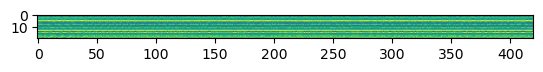

In [209]:
def symbolEntropy(D,base=2):
    value,counts = numpy.unique(D, return_counts=True)
    return entropy(counts,base=base)

def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    #print("I H O",I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes=list(range(width))
    cols=[]
    colh=[]
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh

def getAllIOH(model,source,target,songs,width=20):
    I=[]
    O=[]
    H=[]
    for i in range(len(songs)):
        I.append(songs[i])
        predicted_token_index = predict_next_token(model, source[i])
        if predicted_token_index==target[i][-1]:
            O.append(songs[i])
        else:
            O.append((songs[i]+1)%max(songs))
        H.append(list(model.store[-1].flatten()))
    H=numpy.array(H).transpose()
    imshow(H)
    B=numpy.zeros(H.shape)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr,n_init=10).fit(a)
        B[i]=kmeans.labels_
    print(B.shape)
    H=numpy.zeros((H.shape[1]))
    for i in range(width):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return numpy.array(I),numpy.array(O),H

def shrinkingDecompositionInformation(model,source,target,songs,numbers=[0,1,2,3],width=20):
    allI,allO,H=getAllIOH(model,source,target,songs,width=width)
    collectorSet=dict()
    collectorH=dict()
    for number in numbers:
        I=(1*(songs==number)).astype(int)
        O=(1*(allO==number)).astype(int)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH

def removalIntoVec(res,width,H):
    V=numpy.zeros(width)
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)
    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]
    #V=sqrt(V)
    if V.sum()==0:
        return V
    return V#/V.max()

def removalIntoMatrix(res,width,H):
    M=[]
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)

s,h=shrinkingDecompositionInformation(model,source,target,songs,numbers=list(range(10)),width=20)

In [207]:
M=removalIntoMatrix(s,20,h)

0.014703536095720171 -0.03460333316354136


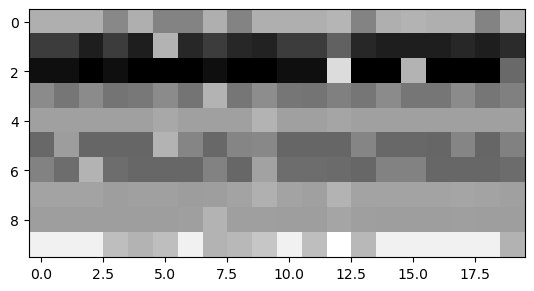

In [208]:
imshow(M,cmap="gray")
print(M.max(),M.min())

(20, 420)


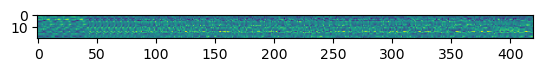

In [201]:
allI,allO,H=getAllIOH(model,source,target,songs,width=20)

In [197]:
number=5
I=(1*(songs==number)).astype(int)
O=(target.transpose()[-1]==allO)

In [202]:
allI

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,

In [203]:
allO

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,

In [195]:
allI

array([2, 2, 2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4, 3,
       6, 6, 5, 5, 4, 4, 3, 2, 2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 5, 0,
       1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4,
       5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 4, 0, 1, 0,
       2, 0, 3, 0, 4, 0, 5, 0, 1, 4, 5, 0, 3, 4, 2, 1, 0, 1, 2, 5, 4, 3,
       4, 5, 0, 1, 2, 0, 3, 4, 1, 0, 2, 0, 3, 5, 0, 1, 1, 3, 1, 2, 0, 2,
       1, 2, 5, 5, 3, 2, 4, 5, 5, 4, 5, 2, 3, 3, 4, 5, 4, 1, 4, 0, 2, 5,
       4, 2, 1, 1, 1, 2, 1, 4, 2, 1, 5, 3, 0, 5, 1, 0, 1, 4, 1, 2, 0, 4,
       5, 2, 3, 5, 5, 1, 2, 1, 3, 1, 1, 1, 2, 4, 3, 2, 1, 5, 1, 5, 5, 4,
       2, 1, 2, 4, 1, 2, 0, 0, 5, 5, 0, 3, 0, 1, 4, 4, 5, 1, 0, 5, 3, 0,
       4, 0, 0, 4, 5, 3, 1, 3, 5, 3, 4, 5, 2, 0, 2, 4, 1, 2, 2, 3, 0, 2,
       4, 0, 2, 0, 2, 4, 4, 3, 1, 0, 2, 1, 5, 4, 1, 5, 4, 4, 1, 3, 1, 2,
       5, 4, 0, 0, 2, 0, 0, 0, 5, 3, 5, 2, 1, 5, 1, 5, 4, 0, 0, 2, 5, 5,
       2, 0, 0, 1, 2, 4, 3, 3, 5, 1, 0, 3, 3, 5, 5,